# Advanced Data Analysis Project
### Prof. Scheideger 
### Coronavirus Pandemic
#### Antoine-Michel Alexeev & Benjamin Souane

This notebook contains the source code and the explanation for our project on the covid-19 pandemic. It is mostly divided into four parts : 

1. Data Import, Data Processing and Data Exploration
2. Predicting the evolution of the pandemic in the countries using a logistic growth model and Gradient descent.
3. Predicting the logistic parameters with specific countries characteristics using machine learning techniques.
4. Predicting the logistic parameters with specific countries characteristics using deep learning techniques.

## 1. Data

### Importing libraries and Data

In [1]:
# Importing the libraries

# Standard libaries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objects as go
import ipywidgets
from ipywidgets import widgets
from pandas.plotting import register_matplotlib_converters

# Utility libraries
import calendar
from datetime import datetime
from decimal import Decimal
import csv

# Machine Learning libraries
import sklearn.model_selection
from sklearn import preprocessing
from sklearn import metrics
from scipy import optimize
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

%matplotlib inline
register_matplotlib_converters()
np.random.seed(1234)

In [2]:
# Importing our Data class
import os 
os.chdir('C:/Users/Benjamin/OneDrive/Documents/GitHub/ADA_Project')
from LoadingData import data
Dataset = data()
Dataset.loadData()

Loading John-Hopkins covid 19 Data
Loading World Bank indicators
Loading from World Data
Loading the Economist Data
Merging all data and selecting only the countries with all the data available
Computing distance between countries !
25 %
50 %
75 %
100 %


(                             GDP  Gini   Dem           Pop  Health  Child  \
 Argentina           5.198715e+11  44.5  70.2  4.449450e+07    4.50    8.8   
 Armenia             1.243309e+10  30.0  47.9  2.951776e+06    3.70   11.0   
 Australia           1.433904e+12  34.7  90.9  2.498269e+07    3.90    3.1   
 Austria             4.552858e+11  30.3  82.9  8.840521e+06    7.70    2.9   
 Belarus             6.003126e+10  28.6  31.3  9.483499e+06   11.50    2.6   
 Belgium             5.427611e+11  28.4  77.8  1.143326e+07    6.50    2.9   
 Bulgaria            6.513295e+10  35.7  70.3  7.025037e+06    6.50    5.9   
 Canada              1.713342e+12  33.6  91.5  3.705776e+07    2.70    4.3   
 China               1.360815e+13  43.7  33.2  1.392730e+09    3.56    7.4   
 Costa Rica          6.013011e+10  48.2  80.7  4.999441e+06    1.20    7.6   
 Croatia             6.097170e+10  32.4  65.7  4.087843e+06    5.60    4.0   
 Cyprus              2.496199e+10  31.5  75.9  1.189265e+06    3

Therefore, we have 59 countries for which the following data are available: 

- y : Daily Cumulatives Cases
- X : Economic, Demographic, ... indicators for each country

The data looks as follow : 

In [3]:
Dataset.X.head()

,GDP,Gini,Dem,Pop,Health,Child,Dens,Trade,Continent,Political Stability,GOV,Distance
Argentina,5.198715e+11,44.5,70.2,44494502.0,4.5,8.8,16.258510,30.700446,South America,0.0199319,0.0259878,19511.435563
Armenia,1.243309e+10,30.0,47.9,2951776.0,3.7,11.0,103.680225,91.288962,Europe,-0.4187803,-0.0243394,6239.009961
Australia,1.433904e+12,34.7,90.9,24982688.0,3.9,3.1,3.247871,43.192261,Oceania,0.9765741,1.596495,6504.224626
Austria,4.552858e+11,30.3,82.9,8840521.0,7.7,2.9,107.127967,107.790262,Europe,0.9175232,1.453342,8344.431208
Belarus,6.003126e+10,28.6,31.3,9483499.0,11.5,2.6,46.719504,139.393736,Europe,0.3535319,-0.3010303,7125.982782


In [4]:
Dataset.y.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
Argentina,0,0,0,0,0,0,0,0,0,0,...,7805,8068,8371,8809,9283,9931,10649,11353,12076,12628
Armenia,0,0,0,0,0,0,0,0,0,0,...,4283,4472,4823,5041,5271,5606,5928,6302,6661,7113
Australia,0,0,0,0,4,5,5,6,9,9,...,7044,7054,7068,7072,7081,7095,7099,7114,7114,7126
Austria,0,0,0,0,0,0,0,0,0,0,...,16201,16242,16269,16321,16353,16404,16436,16486,16503,16539
Belarus,0,0,0,0,0,0,0,0,0,0,...,28681,29650,30572,31508,32426,33371,34303,35244,36198,37144


### Data Exploration

We will now explore our data to see wheter we can use every dataset or some should not be used. This will also allows us to look at the shape of the cumulative cases, therefore allowing us to have a first taste of the kind of distribution that could fit that well.

##### Class imbalances

The first feature of our data that we will explore is the imbalances between the classes. We previously had a "Religion" predictors but sadly more than 90% of the countries where Christian and therefore it was not useful so we did not use it.

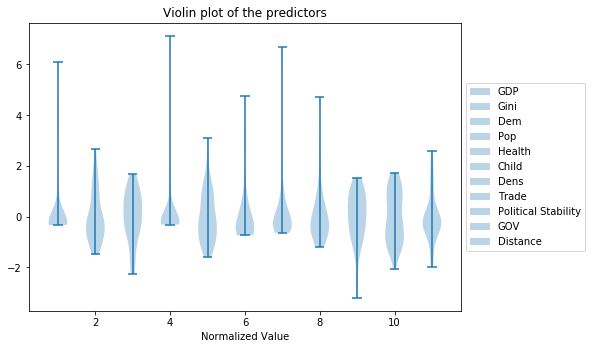

In [5]:
# Data to plot 
toPlot = Dataset.X.drop('Continent',axis=1).astype(float)
toPlot =(toPlot-toPlot.mean())/toPlot.std()

# Instance of the figure
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(toPlot.astype(float).transpose())
ax.set_xlabel('Predictors')
ax.set_xlabel('Normalized Value')
plt.title('Violin plot of the predictors')
legend = ax.legend(toPlot.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('violin.png', bbox_extra_artists=[legend,], bbox_inches='tight')
plt.show()


del toPlot

As we can see most of our data are relatively well balanced, with cleary some extreme values but it do not seem that some indicators should be left out. The indicators continents has been left out because it was categorical but we can see the continent repartition on the next plot. The folllwing table is a numerical representation of the Violin Plot.

In [6]:
def count(myclass,data):
    q = np.linspace(0,1,11)
    quantile = np.array(data[myclass].max()*q)
    count = np.zeros((10,1)).reshape(-1,1)
    for j in range(10):
        subset_count =  (quantile[j] < data[myclass]) & (data[myclass] <= quantile[j+1])
        count[j] = data[myclass][subset_count].count()

    imbalance = pd.DataFrame(np.concatenate((quantile[1:11].reshape(-1,1),count), axis = 1),
                             columns=['Result '+myclass,'# '+myclass])
    
    return imbalance
Dataset.X['Political Stability'] = Dataset.X['Political Stability'].astype(float)
Dataset.X['GOV'] = Dataset.X['GOV'].astype(float)
num_cols=['GDP','Gini','Dem','Pop','Health','Child','Dens','Trade','Political Stability','GOV','Distance']

#GDP
imbalanceGDP = count(num_cols[0],Dataset.X)

#Gini
imbalanceGini = count(num_cols[1], Dataset.X)

#Dem
imbalanceDem = count(num_cols[2], Dataset.X)

#Pop
imbalancePop = count(num_cols[3], Dataset.X)

#Health
imbalanceHealth = count(num_cols[4], Dataset.X)

#Child
imbalanceChild = count(num_cols[5], Dataset.X)

#Dens
imbalanceDens = count(num_cols[6], Dataset.X)

#Trade
imbalanceTrade = count(num_cols[7], Dataset.X)

#Political Stability
imbalanceP = count(num_cols[8], Dataset.X)

#GOV
imbalanceGOV = count(num_cols[9], Dataset.X)


imbalances1 = imbalanceGDP.join([imbalanceGini, imbalanceDem,imbalanceHealth,imbalanceChild])
imbalances2 = imbalanceDens.join([imbalancePop,imbalanceTrade,imbalanceP,imbalanceGOV])

imbalances1.index= ['0-10\%','10-20\%','20-30\%','30-40\%','40-50\%','50-60\%','60-70\%','70-80\%','80-90\%','90-100\%']
imbalances2.index= ['0-10\%','10-20\%','20-30\%','30-40\%','40-50\%','50-60\%','60-70\%','70-80\%','80-90\%','90-100\%']

imbalances1

,Result GDP,# GDP,Result Gini,# Gini,Result Dem,# Dem,Result Health,# Health,Result Child,# Child
0-10\%,2.054434e+12,53.0,5.56,0.0,9.87,0.0,1.15,5.0,5.72,30.0
10-20\%,4.108869e+12,4.0,11.12,0.0,19.74,0.0,2.30,12.0,11.44,15.0
20-30\%,6.163303e+12,0.0,16.68,0.0,29.61,1.0,3.45,10.0,17.16,8.0
30-40\%,8.217737e+12,0.0,22.24,0.0,39.48,4.0,4.60,11.0,22.88,2.0
40-50\%,1.027217e+13,0.0,27.80,7.0,49.35,4.0,5.75,6.0,28.60,1.0
50-60\%,1.232661e+13,0.0,33.36,18.0,59.22,6.0,6.90,8.0,34.32,0.0
60-70\%,1.438104e+13,1.0,38.92,16.0,69.09,13.0,8.05,4.0,40.04,1.0
70-80\%,1.643547e+13,0.0,44.48,8.0,78.96,12.0,9.20,1.0,45.76,1.0
80-90\%,1.848991e+13,0.0,50.04,7.0,88.83,10.0,10.35,1.0,51.48,0.0
90-100\%,2.054434e+13,1.0,55.60,3.0,98.70,9.0,11.50,1.0,57.20,1.0


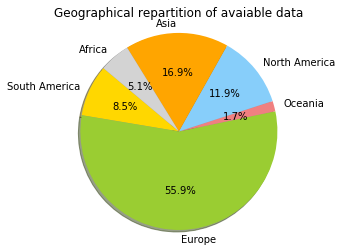

In [7]:
Continents = Dataset.X.loc[:,'Continent'].unique()
count = []
for continent in Continents:
    condObj = Dataset.X.apply(lambda x: True if x['Continent'] == continent else False, axis =1)
    count.append(len(condObj[condObj == True].index))
    

# Data to plot
labels = Continents
sizes = count
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','lightgrey']

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Geographical repartition of avaiable data')
plt.axis('equal')
plt.show()

We can see that clearly we have a lot of european country. However, the other continents are still representing almost 50% of the data, therefore we will keep it as a predictor.

##### Cases Evolution

We will now look at the "y" part of our data with the daily cases on a interactive graph.

In [8]:
countries = np.array(Dataset.y.index)
country_day = Dataset.y.diff(axis=1)

def update_plot(c):     
    data=[] 
    for country in c:
        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = Dataset.y.columns,
            y = Dataset.y.loc[country,:],
            mode = 'lines',
            name = 'Cumulative Cases',
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = Dataset.y.columns,
            y = country_day.loc[country,:],
            mode = 'lines',
            name = 'Daily Cases',
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

c = widgets.SelectMultiple(options=countries, value = ['Armenia'], description='Country')
widgets.interactive(update_plot, c=c)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Argentina', 'Armenia', 'Aust…

On this graph, we could observe three main things : 

1. The countries are not at all is the same step of the pandemic. Indeed, some countries are still experiencing some exponential growth, where as some countries such as switzerland seems to be in a peak. 
2. There is a lot of days with 0 cases in the beginning and we will need to take them out in order to be consistent in our estimation. 
3. Probably the most important observation, the cumulative cases seems to have a sigmoid shape. This observations is also consitsent with a lot of paper describing pandemics evolution with function of the family of Generalized Logisitic Functions. Therefore, we will try and model these data with logistic functions. 

You can see some of those paper here [Ke Wu, Didier Darcet
, Qian Wang and Didier Sornette, 2020](https://ethz.ch/content/dam/ethz/special-interest/mtec/chair-of-entrepreneurial-risks-dam/documents/Covid-19/Paper-Log-modeling_COVID-19_11March2020_sub.pdf) or here [Gerardo Chowell, Lisa Sattenspiel, Shweta Bansal and Cécile Viboud, 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/) and here [Ma, 2019](https://www.sciencedirect.com/science/article/pii/S2468042719300491?via%3Dihub)

Finally, one small "funny" note is that such countries such as "Uruguay" seems to experience negative daily cases. Clearly this due to measurement problems or other "real life" issues but this stress the problem of using actual data and therefore our conclusions will be to take with a grain of salt since we are not sure that all the number are accurate.

##### Finding first cases

Since we have seen that the first cases seems to be quiet different in each country, we will find the first cases in each country and try to see if there is an interesting relation

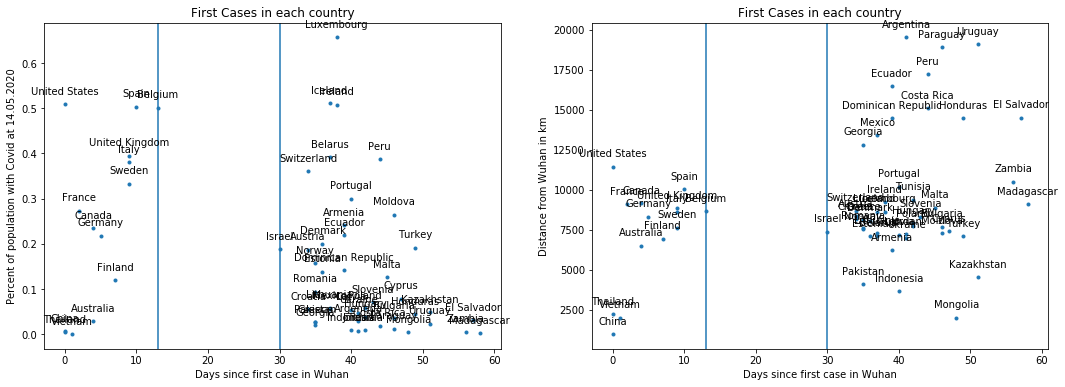

In [9]:
# Finding first case
nonZero = []
InonZero = []
for country in Dataset.y.index:
    for i, date in enumerate(Dataset.y.columns):
        if Dataset.y.loc[country,date] != 0:
            index = Dataset.y.columns.get_loc(date)
            nonZero.append(index)
            InonZero.append(i)
            break
frac = Dataset.y.iloc[:,-1]/Dataset.X.loc[:,'Pop']*100
fig = plt.figure(figsize=[18,6])
plt.subplot(121)
plt.plot(nonZero,frac,'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Percent of population with Covid at 14.05.2020')
count = 0
for x,z in zip(nonZero,frac):
    
    label = Dataset.y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.subplot(122)
plt.plot(nonZero,Dataset.X.loc[:,'Distance'],'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Distance from Wuhan in km')
plt.axvline(x = 13)
plt.axvline(x = 30)
count = 0
for x,z in zip(nonZero,Dataset.X.loc[:,'Distance']):
    
    label = Dataset.y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.show()

del InonZero

As we can on the previous graphs, there seem to be some kind of small relation with the first cases, since a bigger percentage of the population in general seems to have cases of covid. On the other hand the distance from Wuhan does not seem to have a clear relationship. 

One interesting feature is this gap between Belgium and Israel where there seems to have been no new country with cases. This is quiet unrealistic and probably one of the feature that allowed the virus to spread heavily without any bareer measure.

We will now try to look at the correlation between the countries. 

##### Heatmap correlation

In [10]:
corrCountry = country_day.transpose().corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
html = corrCountry.render()
corrCountry

Here we can see the correlation between the countries, it is a relatively high table so its relatively difficult to visualize. However, we can note some interesting features: 

1. China is negatively correlated with every country. This is in part due to the fact that the pandemic started way before and began to decrease when the pandemic started in other countries. 

2. It does not seem that there is very intense relation between neighbours countries which is a bit surprising. However, one must note that there is some high correlation in general. 

3. It is interesting to note that the United Kingdom and the United States have a very high correlation between them, it is probably due to the lack of reaction that both countries had to start lockdown measures. 

It is not really related to our paper but an idea could be to see wheter the correlation could be related to the lockdown strategies. 

### Final Data Preparation

As we've seen before, we have a categorical Data with the Continents, therefore will be pass it a one hot encoder to create binary vectors. Finally we will, add the first data vector to the predictors

#### One hot encoder for religion and continent

In [11]:
FeaturesContinent = Dataset.X['Continent']
Dataset.X = Dataset.X.drop(['Continent'], axis = 1)
enc = preprocessing.LabelEncoder()
encC = enc.fit(FeaturesContinent)
FeaturesContinent = encC.transform(FeaturesContinent)
ohe = preprocessing.OneHotEncoder()
encodedC = ohe.fit(FeaturesContinent.reshape(-1,1))
FeaturesContinent = encodedC.transform(FeaturesContinent.reshape(-1,1)).toarray()
Features = np.concatenate([FeaturesContinent], axis = 1)
Features = np.concatenate([Features, np.array(Dataset.X[['GDP', 'Gini', 'Dem', 'Pop', 'Health','Child',
                                                 'Dens','Trade','Political Stability','GOV','Distance']])], axis = 1)
Data = pd.DataFrame(Features, index = countries, columns= ['South America',
                                                           'Europe', 'Oceania', 'North America','Asia',
                                                           'Africa', 'GDP', 'Gini', 'Dem', 'Pop',
                                                           'Health','Child','Dens','Trade','Political Stability','GOV','Distance'] )

#### Adding first case Data

In [12]:
nonZero = pd.DataFrame(np.array(nonZero),index = countries, columns= {'First Case'})
Data = Data.join(nonZero)

## 2. Predicting the shape of the curve with a logistic model

We will use a gradient descent procedure to do so. We will need : 

1. A algorithm to perform the gradient descent
2. A loss Function
3. A Gradient

More precisely, we will use the mean squared error between our data and the logistic model as a loss function. To perform the optimisation, we had to try a lot of starting point in order to find a global minimum. 

The logistic function has the following form: 

![Logistic Function](https://wikimedia.org/api/rest_v1/media/math/render/svg/9e26947596d387d045be3baeb72c11270a065665 "Logistic Function")

You can find the gradients and more mathematical definition of logistic model in our paper.

##### 1. Gradient descent Algorithm

In [13]:
# Setting gradient descent function
def Newton(w,country,ytrue,x): 
    count = 0
    Maxcount = 10000
    Delta = 1 # Start with a random delta that will decrease,hopefully.
    alpha = 0.001 #alpha
    while count<Maxcount and Delta>10**(-14):
        p = J(w,ytrue,x)
        wOld = w
        w = w - alpha*p
        Delta = np.sum((w-wOld)**2)
        count += 1
    ypred = np.zeros((len(ytrue),1),dtype=np.float64)
    for i in range(len(ytrue)):
        ypred[i] = w[0]/(1+np.exp(w[1]*(w[2]-x[i])))
    return w, ypred

##### 2. Gradient Function

In [14]:
# Setting to compute first derivative
def J(j,ytrue,x):
    gl = 0
    gk = 0
    gx0 = 0
    for i in range(len(ytrue)):
        gl = gl + (j[0]/(1+np.exp(j[1]*(j[2]-x[i])))-ytrue[i])/(1+np.exp(j[1]*(j[2]-x[i])))

        gk = gk + (ytrue[i]-j[0]/(1+np.exp(j[1]*(j[2]-x[i]))))*(j[0]/((1+np.exp(j[1]*(j[2]-x[i])))**2))*(j[2]-x[i])*np.exp(j[1]*(j[2]-x[i]))
    
        gx0 = gx0 + (ytrue[i]-j[0]/(1+np.exp(j[1]*(j[2]-x[i]))))*(j[0]/(1+np.exp(j[1]*(j[2]-x[i])))**2)*j[1]*np.exp(j[1]*(j[2]-x[i]))
        
    gl = 2*gl
    gk = 2*gk
    gx0 = 2*gx0
    p=np.array([gl,gk,gx0], dtype=np.float64)
    return p

##### 3. "Brute Force" Algorithm to find a global minimum

In [15]:
def best(country):
    #Finding first case
    for i, date in enumerate(Dataset.y.columns):
        if Dataset.y.loc[country,date] != 0:
            ytrue = Dataset.y.loc[country,Dataset.y.columns[i-1]:Dataset.y.columns[-2]]
            break
    
    #Set true cumulated cases in % of population
    ytrue = np.array(ytrue/Dataset.X.loc[country,'Pop']*100)
    x = np.linspace(0,len(ytrue)-1,len(ytrue)) 
    
    #Create L,K and X0 points to test
    L = np.linspace(0,1,101)
    K = np.linspace(0,0.3,31)
    X0 = np.linspace(0,100,101)
    
    #Finding best points that gives the min square error between true curve and function curve
    lb = 0
    kb = 0
    x0b = 0
    lsOld = 10000
    for i, l in enumerate(L):
        for j, k in enumerate(K):
            for t, z in enumerate(X0):                
                ls = 0
                for q in range(len(ytrue)):
                    ls = ls + (ytrue[q]-l/(1+np.exp(k*(z-q))))**2  
                if (ls < lsOld):
                    lb = L[i]
                    kb = K[j]
                    x0b = X0[t]
                    lsOld = ls
                else:
                    pass
    
    #With the optimal point we do a Newton gradient descent
    j = np.array([lb,kb,x0b])
    w, ypred = Newton(j, country, ytrue, x)
    return w, ypred, ytrue, x

### Import data

As the optimisation take long time, we stored the results in a csv format, so we can use it fastly afterwards. 

In [16]:
#Reopen data
import csv
with open('Optimal/Time.csv') as csv_file:
    reader = csv.reader(csv_file)
    T = dict(reader)

with open('Optimal/Predictions.csv') as csv_file:
    reader = csv.reader(csv_file)
    Ypred = dict(reader)

with open('Optimal/True.csv') as csv_file:
    reader = csv.reader(csv_file)
    Ytrue = dict(reader)
    
with open('Optimal/W.csv') as csv_file:
    reader = csv.reader(csv_file)
    W = dict(reader)

### Comparing Model and actual Data.

Here we can note that optimisation has been perform on the 29th of april and therefore the days from the 30 april up until today are predicted (out of sample) values

In [17]:
countries = np.array(Dataset.y.index)

In [18]:
def compare_plots(c):     
    data=[] 
    for country in c:
        timing = []
        yt = []
        yp = []
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True' + country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=countries, value = ['Armenia'], description='Country')
widgets.interactive(compare_plots, c=cont)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Argentina', 'Armenia', 'Aust…

As we can see for almost all countries, the model is a very good fit and even the out-of-sample performance is quiet strong. Thus, as we saw previously the pandemic evolution is having a logistic form.

Therefore, here we already have a way to predict the futur evolution of the countries. Now the next step will be to try to predict these logistic parameters using the dataset of predictors. As said previously, this will be done in two step : 

1. Using Machine Learning techniques such as Lasso and Ridge Regression
2. Using Neural Nets

In [40]:
InRsquared = 0
OutRsquared = 0
for country in countries:

    timing = []
    yt = []
    yp = []
    t = T["Time " + country].replace('[', '').replace(']', '').split()
    t = pd.DataFrame(t).values
    Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
    Pred = pd.DataFrame(Pred).values
    true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
    true = pd.DataFrame(true).values
    total = len(Pred)
    inSample = total - 20
    InRsquared = InRsquared + 1 - sum((true[0:inSample].astype(float) - Pred[0:inSample].astype(float))**2)/(sum((true[0:inSample].astype(float) - np.mean(true[0:inSample].astype(float)))**2)+ 0.001)
    
    OutRsquared = OutRsquared +  1 - sum((true[inSample:total].astype(float) - Pred[inSample:total].astype(float))**2)/(sum((true[inSample:total].astype(float) - np.mean(true[inSample:total].astype(float)))**2)+ 0.001)

InRsquared = InRsquared/len(countries)
OutRsquared = OutRsquared/len(countries)

print('In Sample R-squared is {} %'.format(InRsquared*100))
print('Out of Sample R-squared is {} %'.format(OutRsquared*100))

In Sample R-squared is [98.83503416] %
Out of Sample R-squared is [95.79855855] %


## 3. ML Methods

#### Regressions 

We will first arrange the optimal logistic parameters as a pandas DataFrame to be similar to our X and Y values

In [20]:
#We have to arrange the values from the csv to input it in pandas DataFrame
Lmax = []
Ks = []
X0s =[]
for country in countries:
    p = W["Parameters " + country].replace('[', '').replace(']', '').split()
    p = pd.DataFrame(p).values
    ws = []
    for j in p:
        ws.append(float(j))
    Lmax.append(ws[0])
    Ks.append(ws[1])
    X0s.append(ws[2]) 
    
#We format the true value of paremeters in pandas DataFrame
Lmax = pd.DataFrame(Lmax, columns = ['L'], index = countries)
Ks = pd.DataFrame(Ks, columns = ['K'], index = countries)
X0s = pd.DataFrame(X0s, columns = ['x0'], index = countries)
OptiParam = Lmax.join([Ks,X0s])

We will now try to perform the regressions using the following model: 

L (Maximal Value) :  Will be dependant of the GDP, Gini Index and the Population.

K (Growth Rate) : Will be dependant of the Density of population, Gini Index, the Health Indicator and the distance from Wuhan.

X0 (Middle Value) : Dependant of the first case

This is the model we have tought about telling us what parameters could influence the covid-19 cases, the hypothesis are the following : 

1. GDP (per capita) should have a negative effect on the maximal value, indeed in richer countries it must be easier to be in quarantine, typically thanks to the stronger social net. 

2. Gini Index should have, more or less for the same reason as GDP per capita, a positive influence on the number of case, in the sense that the less equal the country, the more the cases. We also used the Gini Index to predict the growth rate. Indeed, typically in New-York it has been shown that the poorer part of the city where the most infected.

3. Since we are predicting cases in percent of population, the population may not have an impact. However, it would be assuming that the number of people in a country has only a linear influence on the number of cases. But a bigger country could typically struggle more to manage a lockdown than a smaller. Therefore, we kept it as a predictor.

4. The Density of population shoud clearly have an impact of the speed of the infection since people would be more or less close. 

5. The number of hospital beds for 1000 people, which is often used as a proxy for the quality of the health system may have an effet. However, we do not really know in which sense it should go. Typically, less equiped country will know that the health system will not hold and therefore take hard measure faster than countries with better system.

6. Distance from Wuhan.

###### 1. Creating a training and testing Split

In [21]:
# Splitting the data
Split = np.random.permutation(Data.index)
NumSplit = 40
TrainSplit = Split[0:NumSplit]
TestSplit = Split[NumSplit:len(Data.index)]

###### 2. Performing the regressions

###### a. Linear Regression

In [22]:
# Importing Libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.linear_model import LinearRegression

# Creating vector of predictors
PredictorL = ['GDP','Gini','Pop']
PredictorK = ['Gini','Dens','Health','Distance']
PredictorX0 = ['First Case']

# zip predictors and targets
Predictors = [PredictorL, PredictorK, PredictorX0]
Targets = [Lmax, Ks, X0s]

# Declaring an instance of the class
LR = LinearRegression()
LinearRegPred = np.zeros([len(TestSplit),3])
LinearRegMetrics = np.zeros([2, 3])
count = 0
for pred, target in zip(Predictors, Targets):
    LR.fit(Data.loc[TrainSplit,pred],target.loc[TrainSplit])
    LinearRegPred[:, count] = LR.predict(Data.loc[TestSplit,pred]).reshape(1,-1)
    LinearRegMetrics[0, count] = LR.score(Data.loc[TestSplit,pred],target.loc[TestSplit])
    LinearRegMetrics[1, count] = metrics.mean_squared_error(target.loc[TestSplit], LinearRegPred[:, count])
    count += 1
    
pd.DataFrame(LinearRegMetrics, columns = ['L','K', 'X0'],index=['Rsquared','MSE'])

,L,K,X0
Rsquared,0.009622,0.014812,-0.036935
MSE,0.032321,0.001246,400.931335


As we can see, this not good at all, we will still try with other regression methods to see if we can yield better results.

###### b. Lasso Regression

In [23]:
# Declaring an instance of the class
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=100)

LassoPred = np.zeros([len(TestSplit),3])
LassoMetrics = np.zeros([2, 3])
count = 0
for pred, target in zip(Predictors, Targets):
    Lasso.fit(Data.loc[TrainSplit,pred],target.loc[TrainSplit])
    LassoPred[:, count] = Lasso.predict(Data.loc[TestSplit,pred]).reshape(1,-1)
    LassoMetrics[0, count] = Lasso.score(Data.loc[TestSplit,pred],target.loc[TestSplit])
    LassoMetrics[1, count] = metrics.mean_squared_error(target.loc[TestSplit], LassoPred[:, count])
    count += 1
    
pd.DataFrame(LassoMetrics, columns = ['L','K', 'X0'],index=['Rsquared','MSE'])

,L,K,X0
Rsquared,-0.084874,-0.049567,-0.067725
MSE,0.035405,0.001328,412.836648


###### c. Gaussian Process

In [24]:
# Declaring an instance of the class

GPR = GaussianProcessRegressor()

GPRPred = np.zeros([len(TestSplit),3])
GPRMetrics = np.zeros([2, 3])
count = 0
for pred, target in zip(Predictors, Targets):
    GPR.fit(Data.loc[TrainSplit,pred],target.loc[TrainSplit])
    GPRPred[:, count] = GPR.predict(Data.loc[TestSplit,pred]).reshape(1,-1)
    GPRMetrics[0, count] = GPR.score(Data.loc[TestSplit,pred],target.loc[TestSplit])
    GPRMetrics[1, count] = metrics.mean_squared_error(target.loc[TestSplit], GPRPred[:, count])
    count += 1
    
pd.DataFrame(GPRMetrics, columns = ['L','K', 'X0'],index=['Rsquared','MSE'])

,L,K,X0
Rsquared,-0.942064,-9.996858,-2.021280
MSE,0.063379,0.013911,1168.179464


Clearly all these results are not very good, eventough, the Gaussian process is improving against the other model, the average Rsquared is smaller than 0 which means that we could probably be better at guessing randomly the results. So it looks our model is not good to predict the curve using these predictors.

However, we will look at the resulted prediction (in terms of covid case) and see what predictions it yields.

##### 3. Prediction Curve 

In [25]:
# We take the predicitons of the parameters and construct the curve with them
def curve_pred(Parameter):
    ypred=np.zeros((len(Parameter),151))
    for i in range(len(Parameter)):
        for j in range(151):
            ypred[i,j]= Parameter[i,0]/(1+np.exp(Parameter[i,1]*(Parameter[i,2]-j)))
    return ypred


ypredLR = curve_pred(LinearRegPred)   
ypredGPR = curve_pred(GPRPred)  
ypredLasso = curve_pred(LassoPred)  

In [26]:
#We plot the true values, the prediction with function and prediciton with regressors

def compare_plots(c):     
    data=[] 
    for count, country in enumerate(c):
        timing = []
        yt = []
        yp = []
        
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred ' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True ' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace3 = go.Scatter(
            x = timing,
            y = ypredLR[count,0:len(yp)],
            mode = 'lines',
            name = 'Linear Regression' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace4 = go.Scatter(
            x = timing,
            y = ypredGPR[count,0:len(yp)],
            mode = 'lines',
            name = 'Gaussian Process' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace5 = go.Scatter(
            x = timing,
            y = ypredLasso[count,0:len(yp)],
            mode = 'lines',
            name = 'Lasso ' + country,
            line = dict(
                shape = 'spline'
            )
        )
        
        data.append(trace1)
        data.append(trace2)
        data.append(trace3)
        data.append(trace4)
        data.append(trace5)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=TestSplit, value = ['Belgium'], description='Country')
widgets.interactive(compare_plots, c=cont)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Estonia', 'Belgium', 'Italy'…

### Neural Network


Epoch: 0, loss:0.6350,  mae:0.7168,  mse:0.6350,  val_loss:0.6046,  val_mae:0.7105,  val_mse:0.6046,  
......................

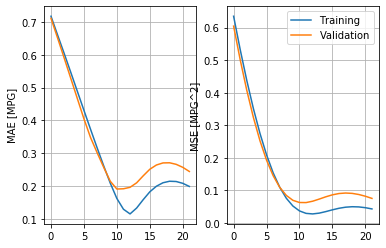

19/19 - 0s - loss: 0.0385 - mae: 0.1873 - mse: 0.0385
Testing set Mean Abs Error:  0.19 MPG

Epoch: 0, loss:0.0666,  mae:0.2155,  mse:0.0666,  val_loss:0.0666,  val_mae:0.2037,  val_mse:0.0666,  
....................

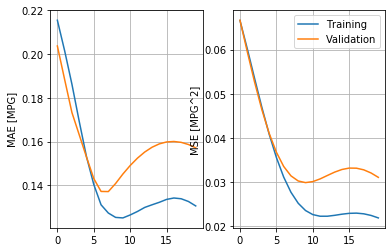

19/19 - 0s - loss: 0.0353 - mae: 0.1724 - mse: 0.0353
Testing set Mean Abs Error:  0.17 MPG

Epoch: 0, loss:2624.6716,  mae:46.1432,  mse:2624.6716,  val_loss:3274.3535,  val_mae:50.8276,  val_mse:3274.3535,  
....................................................................................................
Epoch: 100, loss:2319.6584,  mae:43.1366,  mse:2319.6584,  val_loss:2935.9902,  val_mae:47.6697,  val_mse:2935.9902,  
....................................................................................................
Epoch: 200, loss:2227.3777,  mae:42.1364,  mse:2227.3777,  val_loss:2834.7458,  val_mae:46.7122,  val_mse:2834.7458,  
....................................................................................................
Epoch: 300, loss:2146.3582,  mae:41.2632,  mse:2146.3582,  val_loss:2744.9441,  val_mae:45.8271,  val_mse:2744.9441,  
....................................................................................................
Epoch: 400, loss:2070.3420,  

....................................................................................................
Epoch: 3700, loss:591.9579,  mae:18.8177,  mse:591.9579,  val_loss:967.9997,  val_mae:22.9996,  val_mse:967.9997,  
....................................................................................................
Epoch: 3800, loss:568.9012,  mae:18.4201,  mse:568.9012,  val_loss:939.7835,  val_mae:22.6128,  val_mse:939.7835,  
....................................................................................................
Epoch: 3900, loss:546.8461,  mae:18.0219,  mse:546.8461,  val_loss:912.6431,  val_mae:22.2878,  val_mse:912.6431,  
....................................................................................................
Epoch: 4000, loss:525.7755,  mae:17.6309,  mse:525.7755,  val_loss:886.5599,  val_mae:22.0184,  val_mse:886.5599,  
....................................................................................................
Epoch: 4100, loss:505.6695,  ma

....................................................................................................
Epoch: 7500, loss:242.2046,  mae:12.4420,  mse:242.2046,  val_loss:483.8178,  val_mae:18.9833,  val_mse:483.8178,  
....................................................................................................
Epoch: 7600, loss:241.6333,  mae:12.4199,  mse:241.6333,  val_loss:481.8221,  val_mae:18.9661,  val_mse:481.8221,  
....................................................................................................
Epoch: 7700, loss:241.1752,  mae:12.3997,  mse:241.1752,  val_loss:480.0589,  val_mae:18.9504,  val_mse:480.0589,  
....................................................................................................
Epoch: 7800, loss:240.8125,  mae:12.3812,  mse:240.8125,  val_loss:478.5080,  val_mae:18.9360,  val_mse:478.5080,  
....................................................................................................
Epoch: 7900, loss:240.5294,  ma

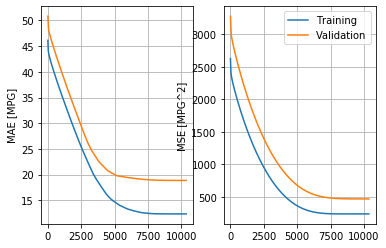

19/19 - 0s - loss: 387.5772 - mae: 14.7303 - mse: 387.5772
Testing set Mean Abs Error: 14.73 MPG
0
1.8429791312080073
0.6200640515298448
-1.9722399269251967
1
0.24733669156400495
0.02403571906936026
-9.29038036475054
2
7363.966269158533
7346.360658965395
-0.002396507741782683


In [27]:
# Model By Benjamin 

# Normalising the data

for indicators in ['GDP', 'Gini', 'Dem', 'Pop', 'Health', 'Child', 'Dens', 'Trade', 'Distance', 'Political Stability', 'GOV']:
    Data.loc[:, indicators] = (Data.loc[:, indicators].astype(float) - np.mean(Data.loc[:, indicators].astype(float)))/np.std(Data.loc[:, indicators].astype(float))

def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[Data.shape[1]]),
        layers.Dense(16, activation='sigmoid'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae', 'mse'])

    return model

def fit_model(Output):

    NN = build_model()
    NN_Predict = np.zeros([19, 3])
    count = 0
    EPOCHS = 100000
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    for output in Output:

        History = NN.fit(Data.loc[TrainSplit, :].astype(float), OptiParam.loc[TrainSplit, [output]].astype(float),
                            epochs=EPOCHS, validation_split=0.3, verbose=0,
                            callbacks=[early_stop, tfdocs.modeling.EpochDots()])
        
        plt.subplot(121)
        plt.plot(History.history['mae'])
        plt.plot(History.history['val_mae'])
        plt.ylabel('MAE [MPG]')
        plt.grid(True)
        plt.subplot(122)
        plt.plot(History.history['mse'])
        plt.plot(History.history['val_mse'])
        plt.legend(['Training', 'Validation'])
        plt.ylabel('MSE [MPG^2]')
        plt.grid(True)
        plt.show()

        loss, mae, mse = NN.evaluate(Data.loc[TestSplit, :].astype(float),
                                     OptiParam.loc[TestSplit, [output]].astype(float), verbose=2)
        print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

        NN_Predict[:, count] = NN.predict(Data.loc[TestSplit, :].astype(float)).reshape(19,)

        count += 1

    return NN_Predict

NN_prediction = fit_model(['K', 'L', 'x0'])

def Rsquared(true, false):
    R2 = 0
    for coefficient in range(true.shape[1]):
        print(coefficient)
        a1 = sum((true.iloc[:, coefficient] - false[:, coefficient])**2)
        print(a1)
        a2 = sum((true.iloc[:, coefficient] - np.mean(true.iloc[:, coefficient]))**2)
        print(a2)
        r = 1 - a1/a2
        print(r)
        R2 = R2 + r
    return R2/3

Rsquared_model = Rsquared(OptiParam.loc[TestSplit, :], NN_prediction)


In [28]:
def customPredict_NN(Weights, y):
    
    YpredAll = np.zeros([y.shape[0],300])
    
    for count, country in enumerate(y.index):
        for time in range(300):
            YpredAll[count, time] = (Weights[count, 1]/(1+np.exp(Weights[count, 0]*(y.loc[country, 'x0']-time))))
            
        
    return YpredAll

Ypred_NN = customPredict_NN(NN_prediction, OptiParam.loc[TestSplit])

In [29]:
#We plot the true values, the prediction with function and prediciton with regressors
def compare_plots(c):     
    data=[] 
    for count, country in enumerate(c):
        timing = []
        yt = []
        yp = []
        
        t = T["Time " + country].replace('[', '').replace(']', '').split()
        t = pd.DataFrame(t).values
        Pred = Ypred["Prediction " + country].replace('[', '').replace(']', '').split()
        Pred = pd.DataFrame(Pred).values
        true = Ytrue["True " + country].replace('[', '').replace(']', '').split()
        true = pd.DataFrame(true).values
        
        for j in t:
            timing.append(float(j))
        for i in Pred:
            yt.append(float(i))
        for i in true:
            yp.append(float(i))  

        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = timing,
            y = yt,
            mode = 'lines',
            name = 'Pred' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace2 = go.Scatter(
            x = timing,
            y = yp,
            mode = 'lines',
            name = 'True' + country,
            line = dict(
                shape = 'spline'
            )
        )
        trace3 = go.Scatter(
            x = timing,
            y =Ypred_NN[count,0:len(yp)],
            mode = 'lines',
            name = 'Model' + country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)
        data.append(trace2)
        data.append(trace3)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

cont = widgets.SelectMultiple(options=list(TestSplit), value = ['Belgium'], description='Country')
widgets.interactive(compare_plots, c=cont)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Estonia', 'Belgium', 'Italy'…

# Death cases

In [30]:
# Loading Covid 19 Data
public_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death_data = pd.read_csv(public_url)
death_data.drop(['Lat','Long','Province/State'],axis=1)
countries = sorted(death_data['Country/Region'].unique())
countryD_data = death_data.groupby('Country/Region').sum()
countryD_data = countryD_data.drop(['Lat','Long'],axis=1)
countryD_data = countryD_data.rename(columns={'Country/Region':'Country'},index={'US':'United States'})

In [31]:
# Getting our available countries
countryD_data = countryD_data.dropna()
countries = Dataset.X.index
countryD_data = countryD_data.loc[countries]

In [32]:
# Display interactive graph
con = list(countryD_data.index)

def update_plot(c):     
    data=[] 
    for country in c:
        layout = go.Layout(
            title = country,
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Date'
                )
            )
        trace1 = go.Scatter(
            x = countryD_data.columns,
            y = countryD_data.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

c = widgets.SelectMultiple(options=con, value = ['Armenia'], description='Country')
widgets.interactive(update_plot, c=c)

interactive(children=(SelectMultiple(description='Country', index=(1,), options=('Argentina', 'Armenia', 'Aust…

In [33]:
distance = countryD_data/Dataset.y
distance = distance.fillna(0)

In [34]:
# Splitting the data
np.random.seed(9988)
Split = np.random.permutation(Data.index)
NumSplit = 40
TrainSplit = Split[0:NumSplit]
TestSplit = Split[NumSplit:len(Data.index)]

# Import Gaussian Process 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Predicting the value with different linear_model
LR = LinearRegression()
GPR = GaussianProcessRegressor()
Ridge = Ridge()
Lasso = Lasso(alpha=10)

#Setting function for prediction

LR.fit(distance.loc[TrainSplit,:],Dataset.X.Child.loc[TrainSplit]/1000)
y_predict = LR.predict(distance.loc[TestSplit,:])
r2 = LR.score(distance.loc[TestSplit,:],Dataset.X.Child.loc[TestSplit]/1000)
MSE = metrics.mean_squared_error(Dataset.X.Child.loc[TestSplit]/1000,y_predict)

GPR.fit(distance.loc[TrainSplit,:],Dataset.X.Child.loc[TrainSplit]/1000)
y_GPRpredict = GPR.predict(distance.loc[TestSplit,:])
r2GPR = GPR.score(distance.loc[TestSplit,:],Dataset.X.Child.loc[TestSplit]/1000)
MSEGPR = metrics.mean_squared_error(Dataset.X.Child.loc[TestSplit]/1000,y_GPRpredict)

Ridge.fit(distance.loc[TrainSplit,:],Dataset.X.Child.loc[TrainSplit]/1000)
y_Ridgepredict = Ridge.predict(distance.loc[TestSplit,:])
r2Ridge = Ridge.score(distance.loc[TestSplit,:],Dataset.X.Child.loc[TestSplit]/1000)
MSERidge = metrics.mean_squared_error(Dataset.X.Child.loc[TestSplit]/1000,y_Ridgepredict)

Lasso.fit(distance.loc[TrainSplit,:],Dataset.X.Child.loc[TrainSplit]/1000)
y_Lassopredict = Lasso.predict(distance.loc[TestSplit,:])
r2Lasso = Lasso.score(distance.loc[TestSplit,:],Dataset.X.Child.loc[TestSplit]/1000)
MSELasso = metrics.mean_squared_error(Dataset.X.Child.loc[TestSplit]/1000,y_Lassopredict)

scores = np.array([r2,MSE,r2GPR,MSEGPR,r2Ridge,MSERidge,r2Lasso,MSELasso]).reshape(-1,1)

In [35]:
Scores = pd.DataFrame(scores, index = ['R2','MSE','R2 GPR','MSE GPR','R2 Ridge','MSE Ridge',
                                       'R2 Lasso','MSE Lasso'],columns=['Child'])